##로지스틱 회귀

-> 확률분포에 이항분포를 사용하고 링크함수에 로짓함수를 사용한 일반선형모델

-> 사용법: 공부시간에 따라 시험 합불 여부가 달라진다 (선형예측자에 0, 1결과일때?)

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.api as sm

%precision 3
%matplotlib inline

가공의 시험 합격 여부 (합격은 1, 불합격은 0)

In [2]:
test_result=pd.read_csv("6-3-1-logistic-regression.csv")
print(test_result.head(3))

   hours  result
0      0       0
1      0       0
2      0       0


공부시간과 합격률 관계 (평균치)

<Axes: xlabel='hours', ylabel='result'>

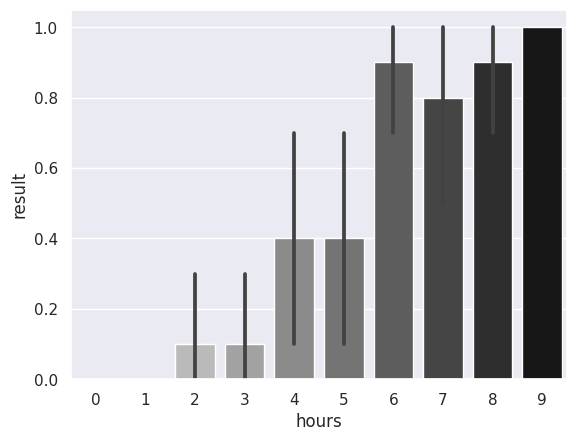

In [3]:
sns.barplot(x='hours',y='result', data=test_result, palette='gray_r')

공부시간마다의 합격률 계산

In [4]:
print(test_result.groupby("hours").mean())

       result
hours        
0         0.0
1         0.0
2         0.1
3         0.1
4         0.4
5         0.4
6         0.9
7         0.8
8         0.9
9         1.0


공부 1시간 이하로 하면 다 불합, 9시간 하면 전부 합

로지스틱 회귀모델 추정

In [5]:
mod_glm=smf.glm(formula="result~hours", data=test_result, family=sm.families.Binomial()).fit()
#이항분포이므로 sm.families.Binomial() / 포아송은 sm.families.Poission()
#이항분포를 지정했을 경우 기본적으로 로짓함수를 링크함수로 지정 / 포아송은 자동으로 로그함수
#sm.families.Binomial(link=sm.families.links.logit())으로 명시 지정해도 됨

In [6]:
mod_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 result   No. Observations:                  100
Model:                            GLM   Df Residuals:                       98
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -34.014
Date:                Mon, 11 Dec 2023   Deviance:                       68.028
Time:                        04:58:59   Pearson chi2:                     84.9
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5032
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.5587      0.901     -5.061      0.000      -6.324      -2.793
hours          0.9289      0.174      5.345      0.000       0.588       1.270
==============================================================================
"""

Method의 IRLS: 최소제곱법의 약자

NO.iterations: 내부에서 계산한 반복수

Deviance, Pearson chi2: 모델 적합도 지표

AIC로 모델 선택

In [7]:
#null 모델
mod_glm_null=smf.glm("result~1",data=test_result, family=sm.families.Binomial()).fit()

In [8]:
print("NULL 모델: ",mod_glm_null.aic.round(3))
print("변수가 있는 모델: ",mod_glm.aic.round(3))

NULL 모델:  139.989
변수가 있는 모델:  72.028


=> 공부시간이라는 변수는 합격률을 예측하는데 도움이 된다

로지스틱 회귀곡선 그래프

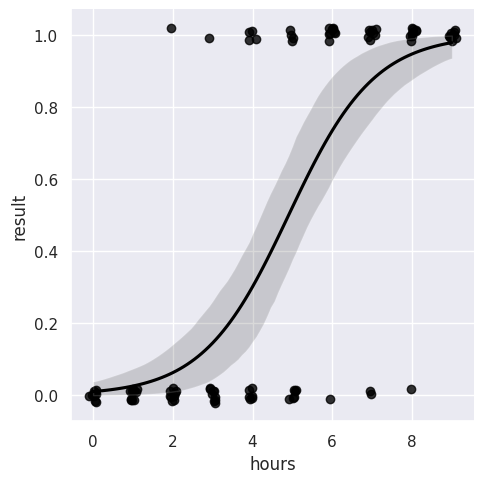

In [10]:
sns.lmplot(x="hours", y="result", data=test_result, logistic=True,
           scatter_kws={"color":"black"},
           line_kws={"color":"black"},
           x_jitter=0.1, y_jitter=0.02)

성공확률 예측

In [11]:
#0~9까지 1씩 증가시키는 등차수열
exp_val=pd.DataFrame({"hours":np.arange(0,10,1)})
#성공확률의 예측치
pred=mod_glm.predict(exp_val)
pred

0    0.010367
1    0.025836
2    0.062920
3    0.145291
4    0.300876
5    0.521427
6    0.733929
7    0.874741
8    0.946467
9    0.978147
dtype: float64

**오즈**

-> 실패하는 것보다 성공하는 것이 몇배 더 쉬운가 p / (1-p)

-> **로그오즈**: 오즈에 로그를 취한 것 (로짓함수: 성공확률을 로그오즈로 변환하는 함수)

-> **오즈비**: 오즈 간에 비율을 취한 것 / **로그오즈비**: 오즈비에 로그를 취한 것

로지스틱 회귀계수와 오즈비의 관계

In [12]:
#공부시간이 1시간일 때의 합격률
exp_val_1=pd.DataFrame({"hours":[1]})
pred_1=mod_glm.predict(exp_val_1)
#공부시간이 2시간일 때의 합격률
exp_val_2=pd.DataFrame({"hours":[2]})
pred_2=mod_glm.predict(exp_val_2)

In [15]:
#오즈
odds_1=pred_1/(1-pred_1)
odds_2=pred_2/(1-pred_2)
#로그오즈비
sp.log(odds_2/odds_1)

array([0.929])

로그오즈비는 공부시간의 계수와 일치

In [16]:
mod_glm.params["hours"]

0.9288901756284946

즉, 계수에 exp를 취한 것이 오즈비

In [17]:
sp.exp(mod_glm.params["hours"])

2.5316978778757737